# Region of Peel food inspection data analysis
# 1. Loading Data

In [58]:
import graphlab as gl
from graphlab import SFrame
import graphlab.aggregate as agg

food = SFrame(".\FoodCheckPeel.csv")
gl.canvas.set_target('ipynb')
%matplotlib inline  
import datetime

import numpy as np

Finished parsing file /home/ubuntu/Peel/FoodCheckPeel.csv

Parsing completed. Parsed 100 lines in 0.424064 secs.

Finished parsing file /home/ubuntu/Peel/FoodCheckPeel.csv

Parsing completed. Parsed 25858 lines in 0.22643 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,int,str,str,str,float,float,float,float,str,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


In [59]:
food.show()

# 2. Data Exploration
    

## 2.1 how many inspections do we have? -> 25858

In [60]:
len(food)

25858

## 2.2 How many facilities? -> 5400

In [61]:
print len(food.groupby(key_columns=['FACILITY_NUMBER'],operations={'count': agg.COUNT()}))

5400


## 2.3 Inpsection breakdown by city

([<matplotlib.patches.Wedge at 0x7fa135423750>,
  <matplotlib.text.Text at 0x7fa135616ad0>])

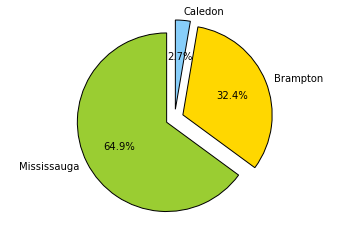

In [62]:
import matplotlib.pyplot as plt

city_group = food.groupby(key_columns=['CITY'],operations={'count': agg.COUNT()})
# The slices will be ordered and plotted counter-clockwise.
labels = city_group['CITY']
sizes =  city_group['count']
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
plt.axis('equal')
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.

## 2.4 What are the top infractions ? 
## Results can be used for extra training on the most common issues. 


In [87]:
infractions = food.groupby(key_columns=['INFRACTION_TYPE'],operations={'count': agg.COUNT()})
infractions = infractions.filter_by([''],'INFRACTION_TYPE',exclude=True)
infractions['percent']=infractions['count']/float(sum(infractions['count']))
# print 'Most common infaction types'
infractions.topk('percent')


INFRACTION_TYPE,count,percent
General,8028,0.38790104368
"Equipment: Construction,Sanitation and Repair ...",6909,0.333832624662
Structural and BuildingMaintenance ...,4534,0.219076149981
Washroom Sanitation,844,0.040780827213
Operator and EmployeeHygiene ...,236,0.0114031696946
Food Disclosure By-Law59-2005 ...,115,0.00555662930035
Health Hazard,22,0.00106300734441
Maintenance,4,0.000193274062621
Pest Control,1,4.83185156552e-05
Dishwashing -Manual/Mechanical ...,1,4.83185156552e-05


### Table above shows that General is too general !

## 2.5 Who are the major chains operating in the area? 

In [64]:
# we first need to reduce multiple records related to a specific store into one
name_number = food.groupby(key_columns=['FACILITY_NUMBER',"FACILITY_NAME"],operations={'count': agg.COUNT()})
facility_name_number  = name_number.groupby(key_columns=["FACILITY_NAME"],operations={'store_count': agg.COUNT()})
print facility_name_number.topk('store_count',20)

+----------------------------+-------------+
|       FACILITY_NAME        | store_count |
+----------------------------+-------------+
|        Tim Hortons         |     109     |
|           Subway           |      92     |
|        Pizza Pizza         |      39     |
|         McDonald's         |      37     |
|        Hasty Market        |      35     |
|     Shoppers Drug Mart     |      31     |
|           Mr Sub           |      21     |
|      Starbucks Coffee      |      20     |
| Petro-Canada - Convenience |      18     |
|          Wendy's           |      18     |
+----------------------------+-------------+
[20 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


## 2.6 How many big chains (>10 stores) and medium sized chains (between 2 and 10 stores ) and Independent stores (only 1 store) exist in this region?

### Independent: 3887 
### Medium: 261
### Big: 32



In [70]:
#let's find the independent stores, medium sized and big chains
chains_gt10 = facility_name_number[facility_name_number['store_count']>10]['FACILITY_NAME']
independent_stores= facility_name_number[facility_name_number['store_count']<2]['FACILITY_NAME']
chains_bw2_20 = facility_name_number[(facility_name_number['store_count']>=2) & (facility_name_number['store_count']<10)]['FACILITY_NAME']

food_big_chains = food.filter_by(chains_gt10,'FACILITY_NAME').filter_by([''],'INFRACTION_TYPE',exclude=True)
food_medium_chains = food.filter_by(chains_bw2_20,'FACILITY_NAME').filter_by([''],'INFRACTION_TYPE',exclude=True)
food_independent_stores = food.filter_by(independent_stores,'FACILITY_NAME').filter_by([''],'INFRACTION_TYPE',exclude=True)
#so, let's calculate the number of ifractions per store in each of the categories

big_add = food_big_chains.groupby(key_columns=["FACILITY_NUMBER"],operations={'count': agg.COUNT()})
med_add = food_medium_chains.groupby(key_columns=["FACILITY_NUMBER"],operations={'count': agg.COUNT()})
ind_add = food_independent_stores.groupby(key_columns=["FACILITY_NUMBER"],operations={'count': agg.COUNT()})
print 'There are',  len(independent_stores), "Independet stores," ,len(chains_bw2_20), "Medium Size stores and", len(chains_gt10), "big Chains in region of peel" 

There are 3887 Independet stores, 261 Medium Size stores and 32 big Chains in region of peel


## 2.7 How "independent stores", "medium sized chains" and "big chais" are compared in terms of number of infractions?
### The restults can be used for choosing the type of stores to do inspection

there are 3887 Independet stores, 261 Medium Size stores and 32 big Chains in region of peel


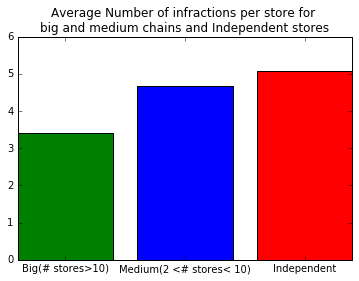

In [44]:
import matplotlib.pyplot as plt

y = [big_add['count'].mean(),med_add['count'].mean(),ind_add['count'].mean()]
N = len(y)
x = range(N)
width = 1/1.5
plt.xticks(range(3), ['Big(# stores>10)','Medium(2 <# stores< 10)','Independent'])
plt.title('Average Number of infractions per store for \nbig and medium chains and Independent stores')
plt.bar(x, y,  color="gbr",align='center')



## 2.8 What are the top infractions by each of the categoies above
### Goal: The result of this analysis could be used to customize training for different store types
### Result: 1. Top infractions are the same. 2. General is to general and does not convey much information

In [46]:
big_infractions= food_big_chains.groupby(key_columns=["INFRACTION_TYPE"],operations={'count': agg.COUNT()})
med_infractions= food_medium_chains.groupby(key_columns=["INFRACTION_TYPE"],operations={'count': agg.COUNT()})
ind_infractions= food_independent_stores.groupby(key_columns=["INFRACTION_TYPE"],operations={'count': agg.COUNT()})
print 'Big Chains:\n', big_infractions.topk('count',5)['INFRACTION_TYPE']
print '\nMedium Chains:\n', med_infractions.topk('count',5)['INFRACTION_TYPE']
print '\nIndependent Stores:\n', ind_infractions.topk('count',5)['INFRACTION_TYPE']

Big Chains:
['General', 'Equipment: Construction, Sanitation and Repair', 'Structural and Building Maintenance', 'Washroom Sanitation', 'Operator and Employee Hygiene']

Medium Chains:
['General', 'Equipment: Construction, Sanitation and Repair', 'Structural and Building Maintenance', 'Washroom Sanitation', 'Operator and Employee Hygiene']

Independent Stores:
['General', 'Equipment: Construction, Sanitation and Repair', 'Structural and Building Maintenance', 'Washroom Sanitation', 'Operator and Employee Hygiene']


## 2.9 Is there such a thing as dirty streets? i.e. Do stores on certain streets receive more infractions on average? We only consider streets with more than 5 stores

In [91]:
food["STREET_NAME_DIR"] = food["STREET_NAME"] + '-' + food["STREET_DIR"]
food_infractions = food.filter_by([''],'INFRACTION_TYPE',exclude=True)

street_store_infractions = food_infractions.groupby(key_columns=['STREET_NAME_DIR','FACILITY_NUMBER'],operations={'count': agg.COUNT()})

#lets find the streets that have more than 5 restaurants

restaurants_per_street = street_store_infractions.groupby(key_columns=['STREET_NAME_DIR'],operations={'count': agg.COUNT()})
streets_morethan5_restaurants = restaurants_per_street[restaurants_per_street['count']>4]["STREET_NAME_DIR"]

#blow shows the number of infractions per store in each street
street_store_infractions  = street_store_infractions.filter_by(streets_morethan5_restaurants,'STREET_NAME_DIR')

street_average_infractopn_per_store = street_store_infractions.groupby(key_columns=['STREET_NAME_DIR'],operations={'mean_infraction_per_restaurant': agg.MEAN('count')})

xx = street_average_infractopn_per_store.topk('mean_infraction_per_restaurant')
xx


STREET_NAME_DIR,mean_infraction_per_restaurant ...
Dream Crest Rd-,12.8
Clarence St-,11.0909090909
Ebenezer Rd-,10.4285714286
Drew Rd-,9.72727272727
Brandon Gate Dr-,9.61538461538
Orenda Rd-,8.875
Philosophers Trail-,8.8
Ashby Field Rd-,8.66666666667
Ray Lawson Blvd-,8.64
The Gore Rd-,8.59090909091


### Looking at the average distribution of infraction per restaurant for each street shows that values in the table above are actually high and indicative of these streets are in fact dirty

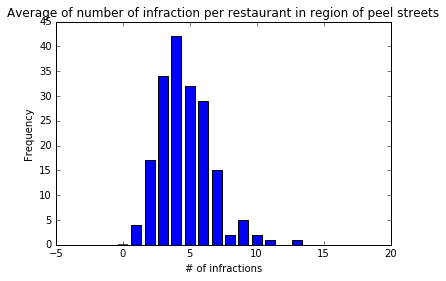

In [71]:
width = 0.75
plt.hist(street_average_infractopn_per_store['mean_infraction_per_restaurant'],bins= np.array(range(20))-width/2,width=width)
plt.title("Average of number of infraction per restaurant in region of peel streets")
plt.xlabel("# of infractions")
plt.ylabel("Frequency")
plt.show()

# 2.10 Which big chains are doing worse than others in terms of numer of interactions per store?

In [72]:
a = food_big_chains.groupby(key_columns=['FACILITY_NAME','FACILITY_NUMBER'],operations={'count': agg.COUNT()})
b= a.groupby(key_columns=['FACILITY_NAME'],operations={'mean_infraction_per_store': agg.MEAN('count')})
print 'Below see a list of big chains with the highest mean of number of infractions per store'
b.topk('mean_infraction_per_store')

Below see a list of big chains with the highest mean of number of infractions per store


FACILITY_NAME,mean_infraction_per_store
Popular Pizza,7.2
Pizza Depot,6.18181818182
Gino's Pizza,6.15384615385
Swiss Chalet Rotisserie &Grill ...,4.83333333333
Mr Sub,4.25
Domino's Pizza,4.16666666667
Pizzaville,4.0
Booster Juice,4.0
Rabba - Food Take Out,3.90909090909
A&W,3.9


# 2.11 Let's see the frequency of the inspections based on weekdays

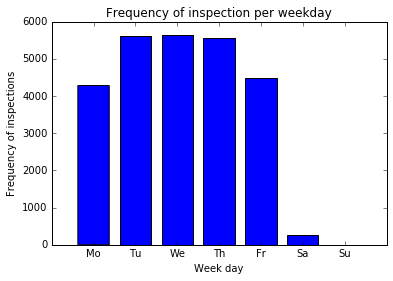

In [73]:
import graphlab.aggregate as agg
food.apply(lambda x: datetime.datetime.strptime(x['INSPECTION_DATE'], "%Y-%m-%d").date() ) ## transforming str to date
weekdays = ["Mo","Tu","We","Th","Fr","Sa","Su"]
weeks_days=dict(zip(range(7),weekdays))

food['DATE'] = map(lambda x: datetime.datetime.strptime(x['INSPECTION_DATE'], "%Y-%m-%d").date(),food)
food['WEEKDAY_CATEGORICAL'] = map(lambda x: weeks_days[x['DATE'].weekday()],food)
food['WEEKDAY_NUMERICAL'] = map(lambda x: x['DATE'].weekday(),food)
#inspection_count = food.groupby(key_columns=['WEEKDAY_CATEGORICAL'],operations={'count': agg.COUNT()})
import matplotlib.pyplot as plt
width = 0.75
plt.hist(food['WEEKDAY_NUMERICAL'],bins= np.array(range(8))-width/2,width=width)
plt.title("Frequency of inspection per weekday")
plt.xlabel("Week day")
plt.ylabel("Frequency of inspections")
plt.xticks(range(7), weekdays)
plt.show()

# 3. What else could we explore?

### 1. We could break down based on the type of facility  (Restaurant, etc.).
### 2. By utilizing data from previous years, we can predict which stores/areas/chains etc. are more likely to have infractions.
### 3. We can use the geographical data to visualize the sanitary condition of restaurant, etc. using a heatmap
##  
## We could also find the answer to the following questions:
### 1. How many of the re-inspections after a CLOSED sign or a CONDITIONAL-PASS sign will lead to a PASS?
### 2. What is the average time between inspections?
### 3. Do all the CONDITIONAL-PASSs lead to a second inspection in a certainm amount of time?
### 4. What is the average time period between a CONDITIONAL-PASS and the next inspection?
